In [17]:
# Load the data
import pandas as pd
train_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/train.csv")
test_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/test.csv")

In [18]:
# Get all of the unique labels for train / test sets 
train_labels = list(train_df['room'].unique())
test_labels = list(test_df['room'].unique())

common_labels = list(set(train_labels) & set(test_labels))

# Now filter the train_df and test_df so that
# remove all record in train_df whose labels not in test labels 
# and remove all record in test_df whose labels not in train labels 
# therefore we can have a proper train and test df such that the labels appear 
# in train and test should be the same and vice versa
train_df = train_df[train_df['room'].isin(common_labels)].reset_index(drop=True)
test_df  = test_df[test_df['room'].isin(common_labels)].reset_index(drop=True)

In [19]:
# Function to add 25 beacon_1, beacon_2, ... , beacon_25
def add_beacon_features(df, num_beacons=25):
    df = df.copy()

    for i in range(1, num_beacons + 1):
        df[f'beacon_{i}'] = df['RSSI'].where(df['mac address'] == i, 0)

    return df

# Apply with our current train and test dataframe
train_df = add_beacon_features(train_df)
test_df = add_beacon_features(test_df)

In [20]:
# ============================================================================
# FIXED VERSION - Proper column naming for 'room'
# ============================================================================

# Cell 1: Define the aggregation function (FIXED)
def aggregate_by_timestamp(df):
    """
    Aggregate beacon data by timestamp (1-second windows)
    Since timestamp is already at second precision, this naturally creates 1-second windows
    """
    df = df.copy()
    
    # Build aggregation dictionary
    agg_dict = {}
    
    # For each of the 25 beacons: mean, std, max, min, count
    for i in range(1, 26):
        beacon_col = f'beacon_{i}'
        agg_dict[beacon_col] = ['mean', 'std', 'max', 'min', 'count']
    
    # For room: take first value (should be consistent within same timestamp)
    agg_dict['room'] = 'first'
    
    # Group by timestamp and aggregate
    windowed_df = df.groupby('timestamp').agg(agg_dict)
    
    # Flatten multi-level column names
    new_columns = []
    for col in windowed_df.columns.values:
        if col[0] == 'room':
            # Keep 'room' as is, don't add '_first'
            new_columns.append('room')
        elif col[1]:
            # For beacon columns, join with underscore
            new_columns.append('_'.join(col))
        else:
            new_columns.append(col[0])
    
    windowed_df.columns = new_columns
    
    # Reset index to make timestamp a regular column
    windowed_df = windowed_df.reset_index()
    
    # Fill NaN (happens when std calculated on single value) with 0
    windowed_df = windowed_df.fillna(0)
    
    # CRITICAL: Filter out windows where NO beacons were detected
    # This prevents the "room 0" issue
    beacon_mean_cols = [f'beacon_{i}_mean' for i in range(1, 26)]
    valid_windows = windowed_df[beacon_mean_cols].sum(axis=1) != 0
    
    removed_count = (~valid_windows).sum()
    windowed_df = windowed_df[valid_windows].reset_index(drop=True)
    
    print(f"Total windows after aggregation: {len(windowed_df)}")
    print(f"Removed {removed_count} empty windows (no beacon detections)")
    
    return windowed_df

# Apply aggregation to test data
print("\nAggregating test data by timestamp...")
windowed_test_df = aggregate_by_timestamp(test_df)

print("\nTest data shape after windowing:", windowed_test_df.shape)
print("\nRoom distribution:")
print(windowed_test_df['room'].value_counts())


Aggregating test data by timestamp...
Total windows after aggregation: 5889
Removed 0 empty windows (no beacon detections)

Test data shape after windowing: (5889, 127)

Room distribution:
room
kitchen          1703
nurse station    1265
cafeteria        1248
cleaning          475
hallway           326
520               190
513               180
512               133
523               110
506                97
502                69
511                46
522                17
501                15
518                13
517                 2
Name: count, dtype: int64


In [21]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load All Models and Encoders
print("Loading models and encoders...")
gatekeeper = joblib.load('models/gatekeeper_zone_model.pkl')
gate_le = joblib.load('models/gatekeeper_label_encoder.pkl')

expert_mid = joblib.load('models/expert_middle_rooms.pkl')
mid_le = joblib.load('models/encoder_middle_rooms.pkl')

expert_left = joblib.load('models/expert_left_rooms.pkl')
left_le = joblib.load('models/encoder_left_rooms.pkl')

expert_right = joblib.load('models/expert_right_rooms.pkl')
right_le = joblib.load('models/encoder_right_rooms.pkl')

Loading models and encoders...


Running Stage 1: Zone Classification...
Running Stage 2: Room Classification...

FINAL 2-STAGE HIERARCHICAL EVALUATION
               precision    recall  f1-score   support

          501       0.14      0.87      0.23        15
          502       0.82      0.26      0.40        69
          506       0.17      0.01      0.02        97
          511       0.35      0.39      0.37        46
          512       0.63      0.40      0.49       133
          513       0.66      0.11      0.18       180
          517       0.03      0.50      0.05         2
          518       0.00      0.00      0.00        13
          520       0.64      0.30      0.41       190
          522       0.14      0.47      0.21        17
          523       0.53      0.63      0.57       110
    cafeteria       0.32      0.43      0.37      1248
     cleaning       0.41      0.39      0.40       475
      hallway       0.04      0.01      0.02       326
      kitchen       0.60      0.40      0.48      1703


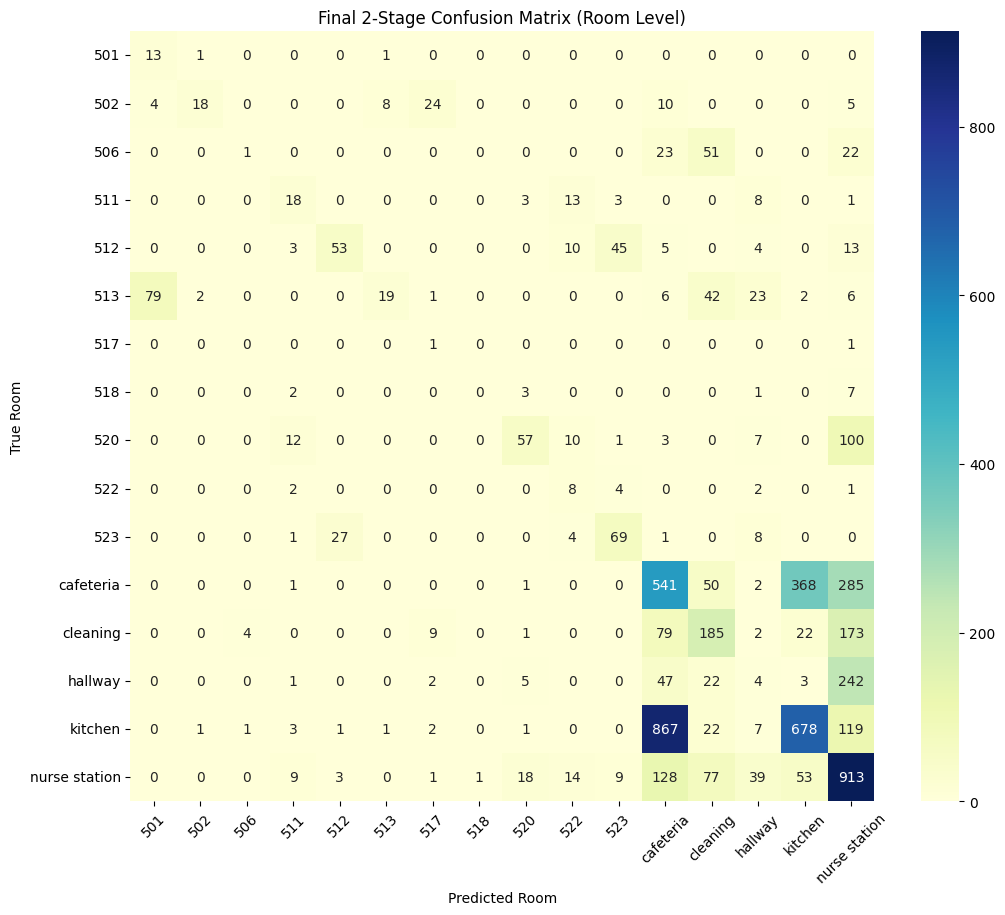

Final Integrated System Accuracy: 0.4378


In [22]:
# 2. Prepare the data
# We assume windowed_test_df has 125 features (25 beacons * 5 stats)
# and a 'room' column as ground truth
X_test_all = windowed_test_df.drop(columns=['timestamp', 'room', 'Zone'], errors='ignore')
y_true_rooms = windowed_test_df['room']

# 3. STAGE 1: Zone Prediction
print("Running Stage 1: Zone Classification...")
zone_preds_numeric = gatekeeper.predict(X_test_all)
zone_preds_labels = gate_le.inverse_transform(zone_preds_numeric)

# 4. STAGE 2: Room Prediction (The Hand-off)
print("Running Stage 2: Room Classification...")
final_room_predictions = []

for i in range(len(windowed_test_df)):
    predicted_zone = zone_preds_labels[i]
    features = X_test_all.iloc[[i]]
    
    if predicted_zone == 'middle':
        # Use Middle Expert
        room_numeric = expert_mid.predict(features)
        room_name = mid_le.inverse_transform(room_numeric)[0]
        
    elif predicted_zone == 'left':
        # Use Left Expert
        room_numeric = expert_left.predict(features)
        room_name = left_le.inverse_transform(room_numeric)[0]
        
    elif predicted_zone == 'right':
        # Use Right Expert
        room_numeric = expert_right.predict(features)
        room_name = right_le.inverse_transform(room_numeric)[0]
        
    else: # Predicted 'hallway' or other
        room_name = 'hallway'
        
    final_room_predictions.append(room_name)

# 5. Final Evaluation
print("\n" + "="*80)
print("FINAL 2-STAGE HIERARCHICAL EVALUATION")
print("="*80)

print(classification_report(y_true_rooms, final_room_predictions))

# Confusion Matrix for Rooms
unique_rooms = sorted(list(set(y_true_rooms) | set(final_room_predictions)))
cm = confusion_matrix(y_true_rooms, final_room_predictions, labels=unique_rooms)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=unique_rooms, yticklabels=unique_rooms)
plt.title('Final 2-Stage Confusion Matrix (Room Level)')
plt.xlabel('Predicted Room')
plt.ylabel('True Room')
plt.xticks(rotation=45)
plt.show()

total_acc = accuracy_score(y_true_rooms, final_room_predictions)
print(f"Final Integrated System Accuracy: {total_acc:.4f}")